In [1]:
# pip install python-louvain
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
import networkx as nx
import networkx.algorithms.community as nxcom
import networkx.algorithms.approximation as nxapp
from community import community_louvain
from collections import Counter
# import graph_tool.all as gt

In [2]:
# read stored data from data_preparation notebook

# %store -r df_airports
# %store -r airports_dict
# %store -r df_merged

In [3]:
# load network
# g = gt.collection.ns["eu_airlines"]
G = nx.read_graphml('data/network.xml')

# Network Properties

## Assortativity

In [4]:
# compute assortativity
assortativity = nx.degree_pearson_correlation_coefficient(G, weight=None)
assortativity

-0.0502235011122901

## Average Clustering Coefficient

In [5]:
# compute clustering coefficient
# different layers mean different airline companies, which can be set to weight 1
# create weighted graph from M
G_Di = nx.DiGraph()
for u,v in G.edges():
    if G_Di.has_edge(u,v):
        G_Di[u][v]['weight'] += 1
    else:
        G_Di.add_edge(u, v, weight=1)

avg_clustering = nx.average_clustering(G_Di)
clustering = nx.clustering(G_Di,weight='weight')
print("avg_clustering",avg_clustering)
print("clustering",clustering)

avg_clustering 0.2090760616709642
clustering {'n0': 0.07793564042335699, 'n1': 0.03866620798638578, 'n37': 0.03367504840026904, 'n251': 0.021577135772702295, 'n70': 0.07148453024347565, 'n63': 0.0450506673652524, 'n202': 0.042289848800385284, 'n41': 0.05865340259483568, 'n75': 0.026686679150663088, 'n87': 0.041692590661584907, 'n13': 0.030678757199037076, 'n64': 0.060435874156205154, 'n25': 0.046939005001770104, 'n54': 0.06042180265969757, 'n6': 0.046919791215673474, 'n7': 0.07846696936766168, 'n9': 0.05866984632403292, 'n14': 0.037958055128067145, 'n16': 0.035815793427701255, 'n17': 0.03443151565194094, 'n19': 0.04599818642701223, 'n21': 0.040431077362934914, 'n23': 0.028323516069678364, 'n26': 0.0571238292307969, 'n27': 0.06083008578579343, 'n29': 0.05976070561236531, 'n30': 0.040811875188851245, 'n31': 0.04701972946762487, 'n33': 0.06543086480584585, 'n34': 0.03577326657205454, 'n39': 0.037579428345546215, 'n40': 0.08692521468848964, 'n42': 0.07726856106939164, 'n44': 0.056868654141

### Airports with largest degrees

In [6]:
degree_list = sorted(G.degree, key=lambda x: x[1], reverse=True)
print("Airports with largest degree:\n")
for i,v in degree_list[:10]:
    node = G.nodes[i]['name']
    print(f'{node}: {v}')

Airports with largest degree:

EHAM: 156
LEMD: 152
EDDM: 139
LEBL: 137
EDDF: 127
EGKK: 124
LOWW: 122
LIRF: 119
LFPG: 118
EGSS: 118


# Community Detection

A community is a group of system constituents who share
common properties and/or play similar roles within the
system. Nodes within the same community tend to be connected
with each other much more frequently within the community
than with nodes outside

We explore comminities withing the airline network with the following
modularity based, random walk an other community detection algorithms:
- Fast greedy (modularity based)
- Multilevel (modularity based)
- Walktrap (random walk)
- Edge betweenness
- Label propagation

**Note:** The lecture mentions another algorithm, Leading eigenvector, which we
will not further explore since it was mentioned that it is neither stable nor
fast to compute.

**Note:** The difficulty of this task is that we do not know the "correct" communities, therefore
we cannot easily compare the performance of the algorithms. What we can do is to compare it with
(a.) geographical location and (b.) with the resulting community detection performed by the
reference paper. We can also reason about the actual computational performance of each
algorithm and its stability which we can use for the discussion of the final report.

Networkx Reference: https://networkx.org/documentation/stable/reference/algorithms/community.html

In [7]:
# compute random vertex color used for commmunity visualisation
memory = {}
def random_color(number, memory):
    if not number in memory:
        r = random.random()
        g = random.random()
        b = random.random()
        memory[number] = (r, g, b, 1.0)
    return memory[number]

# draw community graphs
def draw_community_graph(g, communities, with_labels=True):
    plt.figure(figsize=(8,8))
    # add community attribute
    for set_idx, frozenset in enumerate(communities):
        for node_idx in frozenset:
            g.nodes[node_idx]['community'] = set_idx
    # color mapping
    color_map = [random_color(g.nodes[v]['community'], memory) for v in g.nodes]
    nx.draw(g, with_labels=with_labels, node_color=color_map)
    plt.show()

## Fast greedy Algorithm

Bottom up hierarchical decomposition process. It will merge two current communities
iteratively, with the goal to achieve the maximum modularity gain at local optimal.

In [8]:
G = nx.read_graphml('data/network.xml')
# compute communities
communities_greedy = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
#draw_community_graph(G, communities_greedy, with_labels=False)
print(f'Fast greedy algorithm resulted in {len(communities_greedy)} communities')

Fast greedy algorithm resulted in 40 communities


In [9]:
for i,c in enumerate(communities_greedy):
    print(f'{i}: {len(c)}')

0: 144
1: 135
2: 57
3: 46
4: 20
5: 9
6: 6
7: 1
8: 1
9: 1
10: 1
11: 1
12: 1
13: 1
14: 1
15: 1
16: 1
17: 1
18: 1
19: 1
20: 1
21: 1
22: 1
23: 1
24: 1
25: 1
26: 1
27: 1
28: 1
29: 1
30: 1
31: 1
32: 1
33: 1
34: 1
35: 1
36: 1
37: 1
38: 1
39: 1


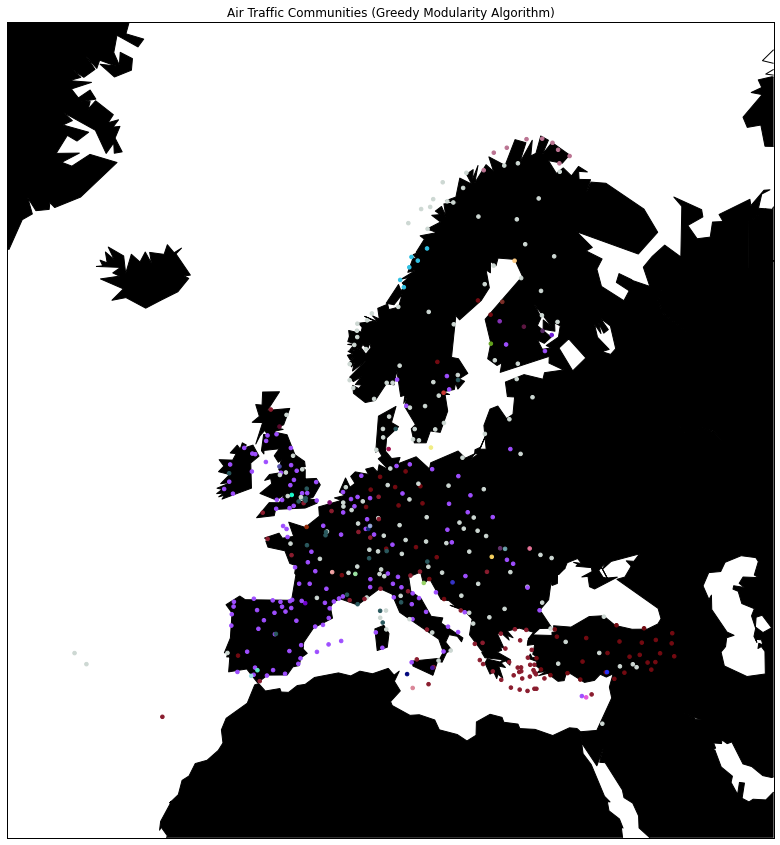

In [10]:
plt.figure(figsize=(15, 15))
map = Basemap(projection='merc', resolution='c',
              llcrnrlat=20, urcrnrlat=75,
              llcrnrlon=-35, urcrnrlon=55,)

pos = {}
for n in G.nodes():
    x,y = map(G.nodes[n]['nodeLong'], G.nodes[n]['nodeLat'])
    pos[n] = (x,y)

# add community attribute
for set_idx, frozenset in enumerate(communities_greedy):
    for node_idx in frozenset:
        G.nodes[node_idx]['community'] = set_idx
# color mapping
color_map = [random_color(G.nodes[v]['community'], memory) for v in G.nodes]
# draw map
map.drawcoastlines()
map.fillcontinents(color='black',lake_color='white')
map.drawmapboundary(fill_color='white')
# map.drawparallels(np.arange(-90.,91.,30.))
# map.drawmeridians(np.arange(-180.,181.,60.))
# map.shadedrelief()
nx.draw_networkx(G, pos=pos, node_size=50, edge_color='r', node_color=color_map,
                 arrows=False, with_labels=False, alpha=1, width=00, node_shape='.')
plt.title('Air Traffic Communities (Greedy Modularity Algorithm)')
plt.savefig('Figures/community/geo_gma.png')
plt.show()

## Multilevel Algorithm

**Idea:** Merge smaller partitions into larger ones as long as the modularity score improves.

In [11]:
G = nx.read_graphml('data/network.xml')
# load network
G_Ud = G.to_undirected()

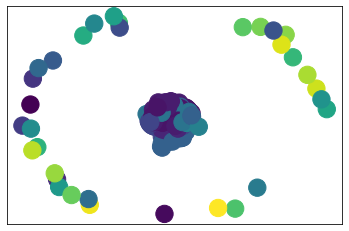

Multilevel algorithm resulted in 40 communities
Counter({2: 101, 3: 94, 15: 82, 12: 69, 4: 39, 8: 30, 17: 2, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 31: 1, 32: 1, 36: 1, 37: 1, 38: 1, 0: 1, 1: 1, 5: 1, 6: 1, 7: 1, 9: 1, 10: 1, 11: 1, 13: 1, 14: 1, 16: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 30: 1, 33: 1, 34: 1, 35: 1, 39: 1})


In [12]:
#plt.figure(figsize=(8, 6))
communities_ml = community_louvain.best_partition(G_Ud)
 # draw the graph
pos = nx.spring_layout(G_Ud)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(communities_ml.values()) + 1)
nx.draw_networkx_nodes(G_Ud, pos, communities_ml.keys(), cmap=cmap, node_color=list(communities_ml.values()))
nx.draw_networkx_edges(G_Ud, pos, alpha=0.5)
plt.show()
count = Counter(communities_ml.values())
print(f'Multilevel algorithm resulted in {len(count)} communities')
print(count)

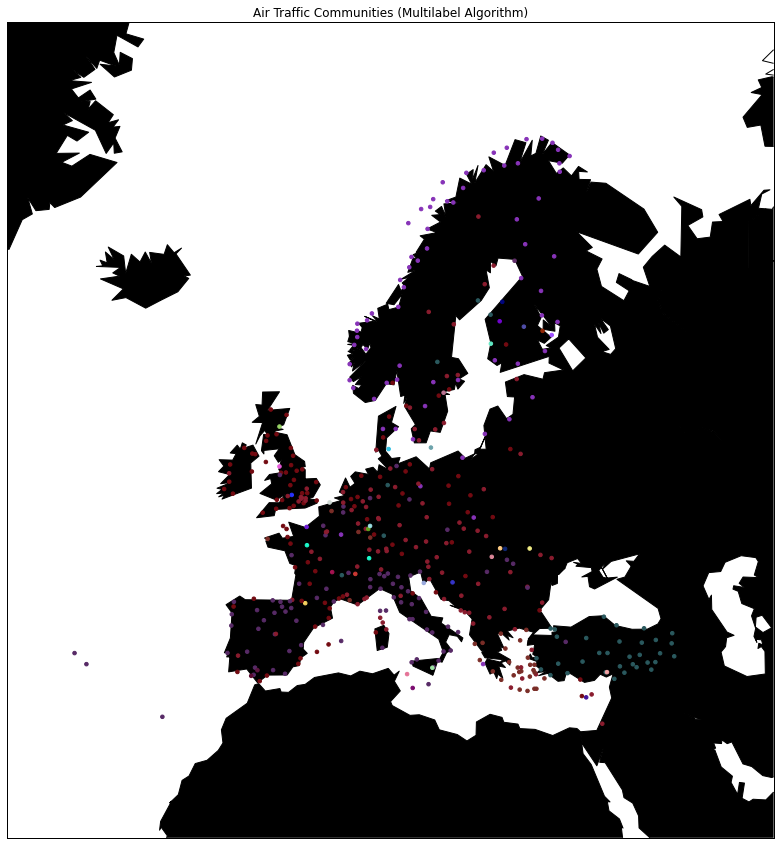

In [13]:
plt.figure(figsize=(15, 15))
map = Basemap(projection='merc', resolution='c',
              llcrnrlat=20, urcrnrlat=75,
              llcrnrlon=-35, urcrnrlon=55,)


pos = {}
for n in G_Ud.nodes():
    x,y = map(G_Ud.nodes[n]['nodeLong'], G_Ud.nodes[n]['nodeLat'])
    pos[n] = (x,y)

# set community attribute
for k in communities_ml:
    G_Ud.nodes[str(k)]['community'] = communities_ml[str(k)]

# color mapping
color_map = [random_color(G_Ud.nodes[v]['community'], memory) for v in G_Ud.nodes]
# draw map
map.drawcoastlines()
map.fillcontinents(color='black',lake_color='white')
map.drawmapboundary(fill_color='white')
# map.shadedrelief()
nx.draw_networkx(G_Ud, pos=pos, node_size=50, edge_color='r', node_color=color_map,
                 arrows=False, with_labels=False, alpha=1, width=00, node_shape='.')
plt.title('Air Traffic Communities (Multilabel Algorithm)')
plt.savefig('Figures/community/geo_mla.png')
plt.show()

## Edge Betweenness Algorithm

**Idea:** Detect communities by progressively removing edges with the highest edge
 betweenness centrality from the original network

*Note:* This algorithm takes too long to compute!

In [14]:
# load network
G = nx.read_graphml('data/network.xml')
# compute communities
communities_eb = sorted(nxcom.girvan_newman(G), key=len, reverse=True)
#draw_community_graph(G, communities_eb, with_labels=False)
print(f'Edge betweenness algorithm resulted in {len(communities_eb)} communities')

Edge betweenness algorithm resulted in 416 communities


In [15]:
for i,c in enumerate(communities_eb):
    print(f'{i}: {len(c)}')

0: 450
1: 449
2: 448
3: 447
4: 446
5: 445
6: 444
7: 443
8: 442
9: 441
10: 440
11: 439
12: 438
13: 437
14: 436
15: 435
16: 434
17: 433
18: 432
19: 431
20: 430
21: 429
22: 428
23: 427
24: 426
25: 425
26: 424
27: 423
28: 422
29: 421
30: 420
31: 419
32: 418
33: 417
34: 416
35: 415
36: 414
37: 413
38: 412
39: 411
40: 410
41: 409
42: 408
43: 407
44: 406
45: 405
46: 404
47: 403
48: 402
49: 401
50: 400
51: 399
52: 398
53: 397
54: 396
55: 395
56: 394
57: 393
58: 392
59: 391
60: 390
61: 389
62: 388
63: 387
64: 386
65: 385
66: 384
67: 383
68: 382
69: 381
70: 380
71: 379
72: 378
73: 377
74: 376
75: 375
76: 374
77: 373
78: 372
79: 371
80: 370
81: 369
82: 368
83: 367
84: 366
85: 365
86: 364
87: 363
88: 362
89: 361
90: 360
91: 359
92: 358
93: 357
94: 356
95: 355
96: 354
97: 353
98: 352
99: 351
100: 350
101: 349
102: 348
103: 347
104: 346
105: 345
106: 344
107: 343
108: 342
109: 341
110: 340
111: 339
112: 338
113: 337
114: 336
115: 335
116: 334
117: 333
118: 332
119: 331
120: 330
121: 329
122: 328
123

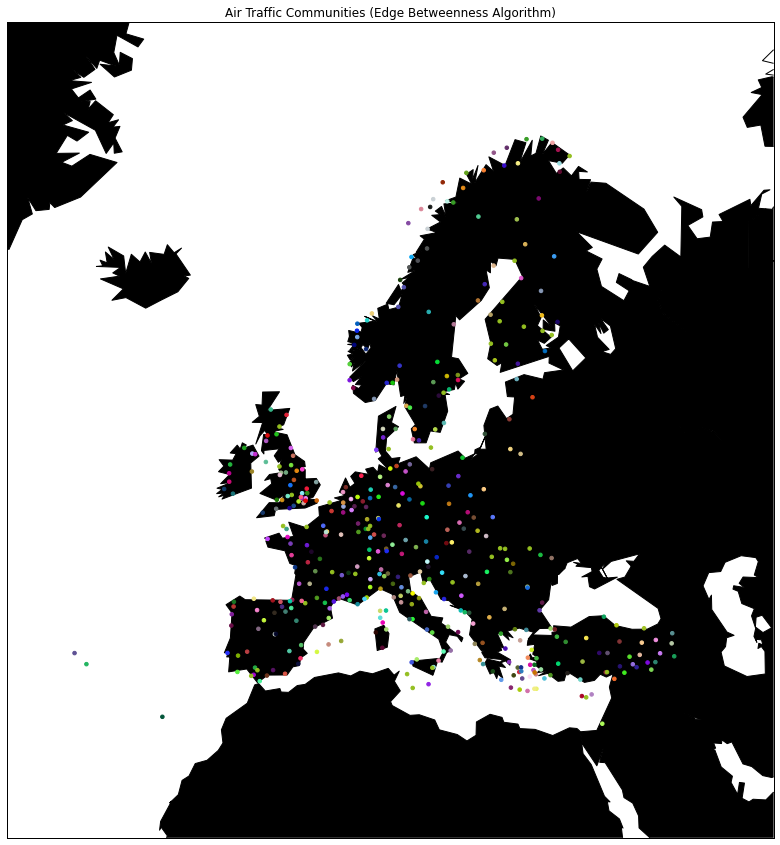

In [16]:
plt.figure(figsize=(15, 15))
map = Basemap(projection='merc', resolution='c',
              llcrnrlat=20, urcrnrlat=75,
              llcrnrlon=-35, urcrnrlon=55,)

pos = {}
for n in G.nodes():
    x,y = map(G.nodes[n]['nodeLong'], G.nodes[n]['nodeLat'])
    pos[n] = (x,y)

# add community attribute
for set_idx, frozenset in enumerate(communities_eb):
    for node_idx in frozenset:
        G.nodes[list(node_idx)[0]]['community'] = int(set_idx)
# color mapping
color_map = [random_color(G.nodes[v]['community'], memory) for v in G.nodes]
# draw map
map.drawcoastlines()
map.fillcontinents(color='black',lake_color='white')
map.drawmapboundary(fill_color='white')
nx.draw_networkx(G, pos=pos, node_size=50, edge_color='r', node_color=color_map,
                 arrows=False, with_labels=False, alpha=1, width=00, node_shape='.')
plt.title('Air Traffic Communities (Edge Betweenness Algorithm)')
plt.savefig('Figures/community/geo_eba.png')
plt.show()

## Label Propagation Algorithm

**Idea:** Assign each node in the network to the community to which belongs the majority
of its neighbours.

In [17]:
# load network
G = nx.read_graphml('data/network.xml')
G_Ud = G.to_undirected();
# compute communities
communities_lp = sorted(nxcom.label_propagation_communities(G_Ud), key=len, reverse=True)
#draw_community_graph(G, communities_lp, with_labels=False)
print(f'Label propagation algorithm resulted in {len(communities_lp)} communities')

Label propagation algorithm resulted in 39 communities


In [18]:
for i,c in enumerate(communities_lp):
    print(f'{i}: {len(c)}')

0: 386
1: 9
2: 7
3: 7
4: 6
5: 2
6: 1
7: 1
8: 1
9: 1
10: 1
11: 1
12: 1
13: 1
14: 1
15: 1
16: 1
17: 1
18: 1
19: 1
20: 1
21: 1
22: 1
23: 1
24: 1
25: 1
26: 1
27: 1
28: 1
29: 1
30: 1
31: 1
32: 1
33: 1
34: 1
35: 1
36: 1
37: 1
38: 1


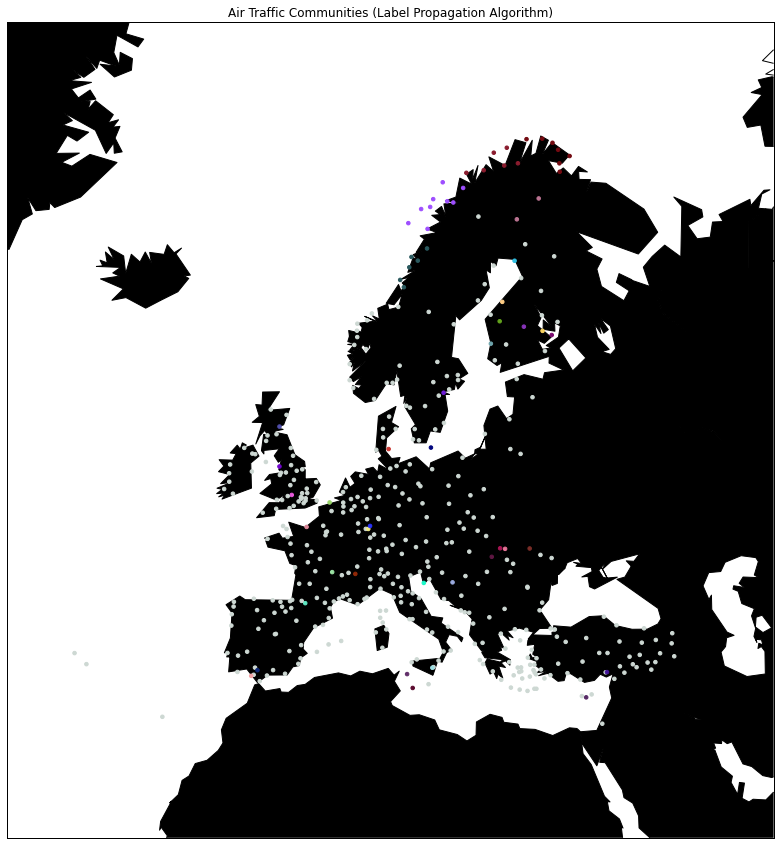

In [19]:
plt.figure(figsize=(15, 15))
map = Basemap(projection='merc', resolution='c',
              llcrnrlat=20, urcrnrlat=75,
              llcrnrlon=-35, urcrnrlon=55,)

pos = {}
for n in G_Ud.nodes():
    x,y = map(G_Ud.nodes[n]['nodeLong'], G_Ud.nodes[n]['nodeLat'])
    pos[n] = (x,y)

# add community attribute
for set_idx, frozenset in enumerate(communities_lp):
    for node_idx in frozenset:
        G_Ud.nodes[node_idx]['community'] = set_idx
# color mapping
color_map = [random_color(G_Ud.nodes[v]['community'], memory) for v in G_Ud.nodes]
# draw map
map.drawcoastlines()
map.fillcontinents(color='black',lake_color='white')
map.drawmapboundary(fill_color='white')
nx.draw_networkx(G_Ud, pos=pos, node_size=50, edge_color='r', node_color=color_map,
                 arrows=False, with_labels=False, alpha=1, width=00, node_shape='.')
plt.title('Air Traffic Communities (Label Propagation Algorithm)')
plt.savefig('Figures/community/geo_lpa.png')
plt.show()

## PageRank

- Computes a ranking of the nodes in the graph based on the structure of the incoming links.
- For a cluster center that we have found, display representative ones.

In [20]:
# make new graph with sum of weights on each edge
G = nx.read_graphml('data/network.xml')
H = nx.Graph()
for u,v,d in G.edges(data=True):
    w = d['weight']
    if H.has_edge(u,v):
        H[u][v]['weight'] += 1
    else:
        H.add_edge(u,v,weight=1)

# print(H.edges(data=True))
# compute communities
communities_pr = sorted(nx.pagerank(H), key=len, reverse=True)
print(f'Label propagation algorithm resulted in {len(communities_pr)} communities')

Label propagation algorithm resulted in 417 communities


In [21]:
for i,c in enumerate(communities_pr):
    print(f'{i}: {len(c)}')

0: 4
1: 4
2: 4
3: 4
4: 4
5: 4
6: 4
7: 4
8: 4
9: 4
10: 4
11: 4
12: 4
13: 4
14: 4
15: 4
16: 4
17: 4
18: 4
19: 4
20: 4
21: 4
22: 4
23: 4
24: 4
25: 4
26: 4
27: 4
28: 4
29: 4
30: 4
31: 4
32: 4
33: 4
34: 4
35: 4
36: 4
37: 4
38: 4
39: 4
40: 4
41: 4
42: 4
43: 4
44: 4
45: 4
46: 4
47: 4
48: 4
49: 4
50: 4
51: 4
52: 4
53: 4
54: 4
55: 4
56: 4
57: 4
58: 4
59: 4
60: 4
61: 4
62: 4
63: 4
64: 4
65: 4
66: 4
67: 4
68: 4
69: 4
70: 4
71: 4
72: 4
73: 4
74: 4
75: 4
76: 4
77: 4
78: 4
79: 4
80: 4
81: 4
82: 4
83: 4
84: 4
85: 4
86: 4
87: 4
88: 4
89: 4
90: 4
91: 4
92: 4
93: 4
94: 4
95: 4
96: 4
97: 4
98: 4
99: 4
100: 4
101: 4
102: 4
103: 4
104: 4
105: 4
106: 4
107: 4
108: 4
109: 4
110: 4
111: 4
112: 4
113: 4
114: 4
115: 4
116: 4
117: 4
118: 4
119: 4
120: 4
121: 4
122: 4
123: 4
124: 4
125: 4
126: 4
127: 4
128: 4
129: 4
130: 4
131: 4
132: 4
133: 4
134: 4
135: 4
136: 4
137: 4
138: 4
139: 4
140: 4
141: 4
142: 4
143: 4
144: 4
145: 4
146: 4
147: 4
148: 4
149: 4
150: 4
151: 4
152: 4
153: 4
154: 4
155: 4
156: 4
157: 4
158:

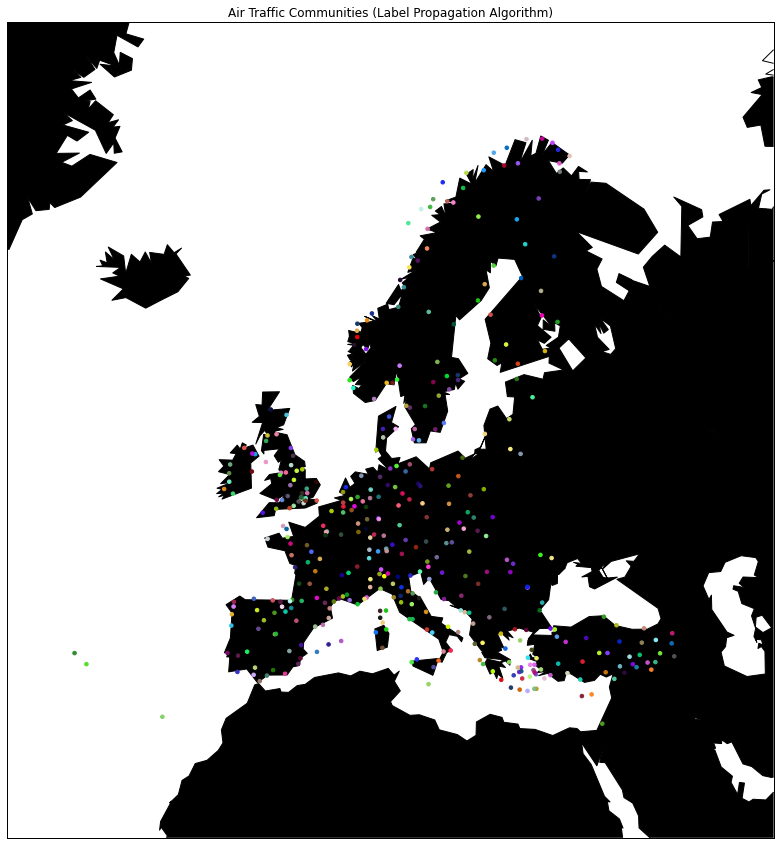

In [22]:
plt.figure(figsize=(15, 15))
map = Basemap(projection='merc', resolution='c',
              llcrnrlat=20, urcrnrlat=75,
              llcrnrlon=-35, urcrnrlon=55,)

pos = {}
for n in H.nodes():
    x,y = map(G.nodes[n]['nodeLong'], G.nodes[n]['nodeLat'])
    pos[n] = (x,y)

# add community attribute
for set_idx, frozenset in enumerate(communities_pr):
    H.nodes[frozenset]['community'] = set_idx
# color mapping
color_map = [random_color(H.nodes[v]['community'], memory) for v in H.nodes]
# draw map
map.drawcoastlines()
map.fillcontinents(color='black',lake_color='white')
map.drawmapboundary(fill_color='white')
nx.draw_networkx(H, pos=pos, node_size=50, edge_color='r', node_color=color_map,
                 arrows=False, with_labels=False, alpha=1, width=00, node_shape='.')
plt.title('Air Traffic Communities (Label Propagation Algorithm)')
plt.savefig('Figures/community/geo_pr.png')
plt.show()